<a href="https://colab.research.google.com/github/esihsi/colab-ML/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import copy
from collections import defaultdict
import json

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [37]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep  6 14:07:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             52W /  400W |    2185MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [38]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [39]:
class ImageNetSubsetDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        # Get all class folders
        self.classes = sorted([d for d in os.listdir(data_dir)
                              if os.path.isdir(os.path.join(data_dir, d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        # Collect all image paths and labels
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

In [40]:
def create_data_transforms():
    """Create transforms for training, validation, and test sets"""

    # ImageNet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Training transforms with data augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Validation and test transforms (no augmentation)
    val_test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    return train_transforms, val_test_transforms


In [41]:
def create_data_loaders(dataset_path, batch_size=32):
    """Create DataLoaders for train, validation, and test sets"""

    train_transforms, val_test_transforms = create_data_transforms()

    # Create datasets
    train_dataset = ImageNetSubsetDataset(
        os.path.join(dataset_path, 'train'),
        transform=train_transforms
    )

    val_dataset = ImageNetSubsetDataset(
        os.path.join(dataset_path, 'val'),
        transform=val_test_transforms
    )

    test_dataset = ImageNetSubsetDataset(
        os.path.join(dataset_path, 'test'),
        transform=val_test_transforms
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Classes: {train_dataset.classes}")

    return train_loader, val_loader, test_loader, train_dataset.classes

In [43]:
def create_model(model_name, num_classes=10, pretrained=True):
    """Create and modify pretrained models for 10-class classification"""

    if model_name == 'resnet18':
        model = models.resnet18(pretrained=pretrained)
        # Replace the final fully connected layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)

    elif model_name == 'resnet34':
        model = models.resnet34(pretrained=pretrained)
        # Replace the final fully connected layer
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)

    elif model_name == 'vgg19':
        model = models.vgg19(pretrained=pretrained)
        # Replace the final classifier
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)

    else:
        raise ValueError(f"Model {model_name} not supported")

    return model


In [44]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    return epoch_loss, epoch_acc

def train_model(model_name, model, train_loader, val_loader, num_epochs=75, learning_rate=0.001):
    """Complete training loop with validation"""

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if 'resnet' in model_name:
            optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    else:  # VGG
            optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Track training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f"Training on {device}")
    print("-" * 60)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Train phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Step the scheduler
        scheduler.step()

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc.item())
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc.item())

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Print epoch results
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs} ({epoch_time:.1f}s)')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Current LR: {scheduler.get_last_lr()[0]:.6f}')
        print("-" * 60)

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f'Best Validation Accuracy: {best_acc:.4f}')

    return model, history

In [45]:
def evaluate_model(model, test_loader, device, classes):
    """Evaluate model on test set and return detailed metrics"""
    model.eval()

    all_preds = []
    all_labels = []
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

    # Cast running_corrects to float before division
    test_acc = float(running_corrects) / total_samples

    # Calculate per-class accuracy
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    for pred, label in zip(all_preds, all_labels):
        class_total[label] += 1
        if pred == label:
            class_correct[label] += 1

    class_accuracies = {}
    for class_idx in range(len(classes)):
        if class_total[class_idx] > 0:
            class_accuracies[classes[class_idx]] = class_correct[class_idx] / class_total[class_idx]
        else:
            class_accuracies[classes[class_idx]] = 0.0

    return test_acc, class_accuracies

def plot_training_history(history, model_name):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [48]:
DATASET_PATH = "/content/drive/MyDrive/dataset8"  # Update this path
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001 # Added definition for WEIGHT_DECAY

# Models to train
MODEL_NAMES = ['resnet18', 'resnet34', 'vgg19']

def main():
    """Main execution function"""

    # Create data loaders
    print("Loading dataset...")
    train_loader, val_loader, test_loader, classes = create_data_loaders(
        DATASET_PATH, batch_size=BATCH_SIZE
    )

    # Results storage
    results = {}

    # Train each model
    for model_name in MODEL_NAMES:
        print(f"\n{'='*80}")
        print(f"Training {model_name.upper()}")
        print(f"{'='*80}")

        # Create model
        model = create_model(model_name, num_classes=len(classes))
        model = model.to(device)


        # Train model
        trained_model, history = train_model(model_name,
            model, train_loader, val_loader,
            num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE
        )

        # Evaluate on test set
        test_acc, class_acc = evaluate_model(trained_model, test_loader, device, classes)

        # Store results
        results[model_name] = {
             'test_accuracy': test_acc,
             'class_accuracies': class_acc,
             'history': history
         }

        print(f"\n{model_name.upper()} Test Accuracy: {test_acc:.4f}")
        print("Per-class accuracies:")
        for class_name, acc in class_acc.items():
            print(f"  {class_name}: {acc:.4f}")

        # Plot training curves
        plot_training_history(history, model_name.upper())

        # Save model
        model_path = f"{model_name}_model.pth"
        torch.save(trained_model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

    # Print final comparison
    print(f"\n{'='*80}")
    print("FINAL RESULTS COMPARISON")
    print(f"{'='*80}")

    for model_name, result in results.items():
        print(f"{model_name.upper()}: Test Accuracy = {result['test_accuracy']:.4f}")

    # Find best model
    best_model = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
    print(f"\nBest Model: {best_model.upper()} with accuracy {results[best_model]['test_accuracy']:.4f}")

    return results

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading dataset...
Training samples: 12438
Validation samples: 500
Test samples: 500
Number of classes: 10
Classes: ['n02690373', 'n02692877', 'n02782093', 'n03773504', 'n04008634', 'n04266014', 'n04285008', 'n04509417', 'n04552348', 'n04592741']

Training RESNET18
Training on cuda
------------------------------------------------------------
Epoch 1/30 (1292.8s)
Train Loss: 1.1595 Acc: 0.6011
Val Loss: 0.8628 Acc: 0.7020
Current LR: 0.001000
------------------------------------------------------------
Epoch 2/30 (86.2s)
Train Loss: 0.8902 Acc: 0.6823
Val Loss: 0.7864 Acc: 0.7220
Current LR: 0.001000
------------------------------------------------------------
Epoch 3/30 (86.5s)
Train Loss: 0.7965 Acc: 0.7114
Val Loss: 0.8361 Acc: 0.7200
Current LR: 0.001000
------------------------------------------------------------
Epoch 4/30 (86.4s)
Train Loss: 0.7274 Acc: 0.7292
Val Loss: 0.6869 Acc: 0.7400
Current LR: 0.001000
------------------------------------------------------------
Epoch 5/30

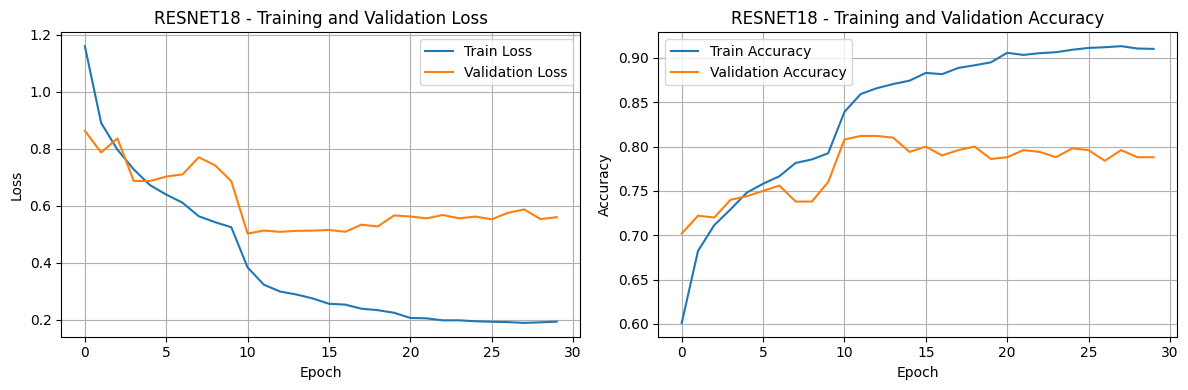

Model saved to resnet18_model.pth

Training RESNET34


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 201MB/s]


Training on cuda
------------------------------------------------------------
Epoch 1/30 (87.2s)
Train Loss: 1.3752 Acc: 0.5277
Val Loss: 1.2112 Acc: 0.6220
Current LR: 0.001000
------------------------------------------------------------
Epoch 2/30 (86.5s)
Train Loss: 1.0014 Acc: 0.6481
Val Loss: 0.9119 Acc: 0.6800
Current LR: 0.001000
------------------------------------------------------------
Epoch 3/30 (86.9s)
Train Loss: 0.8744 Acc: 0.6888
Val Loss: 0.9143 Acc: 0.6700
Current LR: 0.001000
------------------------------------------------------------
Epoch 4/30 (87.1s)
Train Loss: 0.7850 Acc: 0.7120
Val Loss: 0.8125 Acc: 0.7100
Current LR: 0.001000
------------------------------------------------------------
Epoch 5/30 (87.1s)
Train Loss: 0.7287 Acc: 0.7282
Val Loss: 0.6430 Acc: 0.7660
Current LR: 0.001000
------------------------------------------------------------
Epoch 6/30 (86.9s)
Train Loss: 0.6772 Acc: 0.7445
Val Loss: 0.6678 Acc: 0.7640
Current LR: 0.001000
-----------------

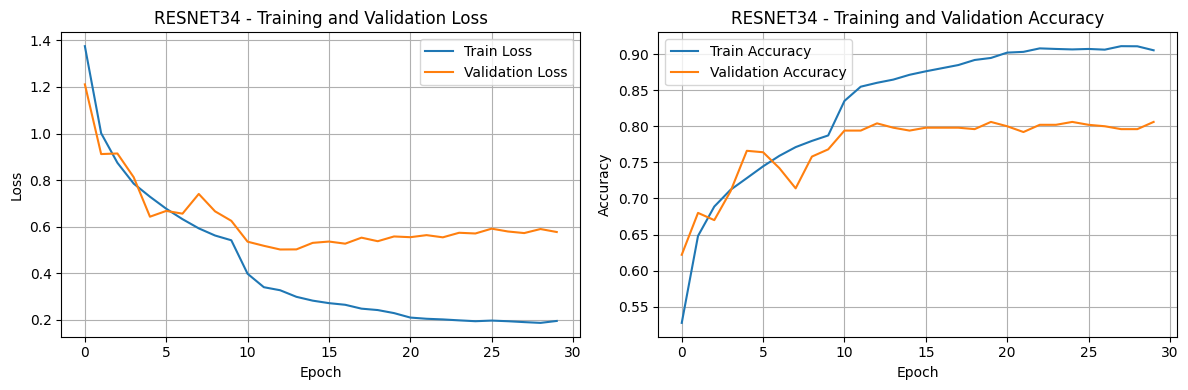

Model saved to resnet34_model.pth

Training VGG19


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 154MB/s]


Training on cuda
------------------------------------------------------------
Epoch 1/30 (89.1s)
Train Loss: 0.6339 Acc: 0.7620
Val Loss: 0.3950 Acc: 0.8580
Current LR: 0.001000
------------------------------------------------------------
Epoch 2/30 (87.0s)
Train Loss: 0.4448 Acc: 0.8199
Val Loss: 0.3415 Acc: 0.8560
Current LR: 0.001000
------------------------------------------------------------
Epoch 3/30 (86.7s)
Train Loss: 0.3885 Acc: 0.8380
Val Loss: 0.3193 Acc: 0.8700
Current LR: 0.001000
------------------------------------------------------------
Epoch 4/30 (87.1s)
Train Loss: 0.3435 Acc: 0.8513
Val Loss: 0.3375 Acc: 0.8560
Current LR: 0.001000
------------------------------------------------------------
Epoch 5/30 (86.9s)
Train Loss: 0.3181 Acc: 0.8644
Val Loss: 0.3249 Acc: 0.8660
Current LR: 0.001000
------------------------------------------------------------
Epoch 6/30 (87.5s)
Train Loss: 0.2962 Acc: 0.8710
Val Loss: 0.3477 Acc: 0.8460
Current LR: 0.001000
-----------------

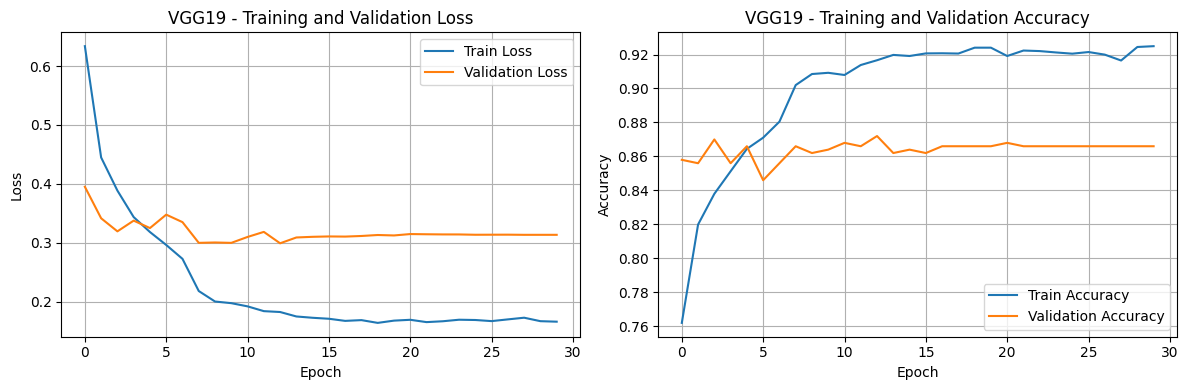

Model saved to vgg19_model.pth

FINAL RESULTS COMPARISON
RESNET18: Test Accuracy = 0.8120
RESNET34: Test Accuracy = 0.8060
VGG19: Test Accuracy = 0.8720

Best Model: VGG19 with accuracy 0.8720


In [50]:
results = main()